# Softmax regression

- MNIST
- ImageNet 1,000,000 images with 1,000 classes
- Kaggle

$$
\begin{aligned}
&\mathbf{y}=\left[y_{1}, y_{2}, \ldots, y_{n}\right]^{\top} \\
&y_{i}=\left\{\begin{array}{l}
1 \text { if } i=y \\
0 \text { otherwise }
\end{array}\right.
\end{aligned}
$$

- the index of the maximum value is the output classification

$$
\hat{y}=\underset{i}{\operatorname{argmax}} o_{i}
$$

- threshold

$$
o_y - o_i \geqslant \Delta(y, i)
$$

- output the probability

$$
\begin{aligned}
\hat{\mathbf{y}} &=\operatorname{softmax}(\mathbf{o}) \\
\hat{y}_{i} &=\frac{\exp \left(o_{i}\right)}{\sum_{k} \exp \left(o_{k}\right)}
\end{aligned}
$$

- cross entropy

$$
H(\mathbf{p}, \mathbf{q})=\sum_{i}-p_{i} \log \left(q_{i}\right)
$$

- be viewed as loss

$$
l(\mathbf{y}, \hat{\mathbf{y}})=-\sum_{i} y_{i} \log \hat{y}_{i}=-\log \hat{y}_{y}
$$

- the gradient of it represents the difference between real probability and predicted probability

$$
\partial_{o_{i}} l(\mathbf{y}, \hat{\mathbf{y}})=\operatorname{softmax}(\mathbf{o})_{i}-y_{i}
$$

- Softmax regression is a multi-classfication model


# Loss function

- L2

$$
l\left(y, y^{\prime}\right)=\frac{1}{2}\left(y-y^{\prime}\right)^{2}
$$

- L1

$$
l(y, y') = |y - y'|
$$

- Huber

$$
l\left(y, y^{\prime}\right)= \begin{cases}\left|y-y^{\prime}\right|-\frac{1}{2} & \text { if }\left|y-y^{\prime}\right|>1 \\ \frac{1}{2}\left(y-y^{\prime}\right)^{2} & \text { otherwise }\end{cases}
$$


In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [52]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True, 
                                                transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, 
                                               transform=trans, download=True)
print(len(mnist_train))
print(len(mnist_test))

60000
10000


In [3]:
print(mnist_train[0][0].shape)

torch.Size([1, 28, 28])


In [4]:
def get_fashion_mnist_labels(labels):
    text_labels = [
        "t-shirts", "trouser", "pullover", "dress", "coat", "sandal",
        "shirts", "sneaker", "bag", "ankle boot"
    ]
    return [text_labels[int(i)] for i in labels]

In [5]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    # print(titles)
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirts'}>,
       <AxesSubplot:title={'center':'t-shirts'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirts'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirts'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirts'}>,
       <AxesSubplot:title={'center':'shirts'}>,
       <AxesSubplot:title={'center':'coat'}>], dtype=object)

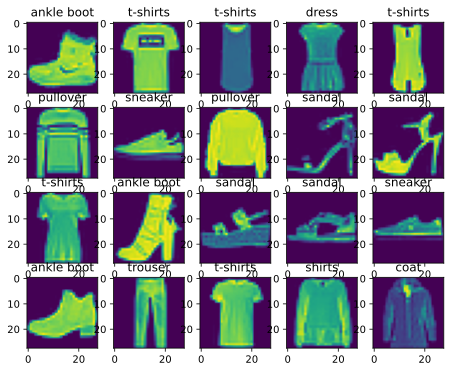

In [6]:
X, y =next(iter(data.DataLoader(mnist_train, batch_size=20)))
show_images(X.reshape(20, 28, 28), 4, 5, titles=get_fashion_mnist_labels(y))

In [9]:
batch_size = 256

def get_dataloader_workers():
    return 8

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [10]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.8f} sec'

'11.16000175 sec'

In [11]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [12]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [19]:
import torch
from IPython import display
from d2l import torch as d2l
import numpy as np

In [20]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [22]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [24]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print(X.sum(0, keepdim=True), "\n", X.sum(1, keepdim=True))

tensor([[5., 7., 9.]]) 
 tensor([[ 6.],
        [15.]])


$$
\operatorname{softmax}(\mathbf{X})_{i j}=\frac{\exp \left(\mathbf{X}_{i j}\right)}{\sum_{k} \exp \left(\mathbf{X}_{i k}\right)}
$$

In [25]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # broadcasting mechanism

In [26]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
print(X_prob)
print(X_prob.sum(1))

tensor([[0.0424, 0.0621, 0.1706, 0.5123, 0.2127],
        [0.1863, 0.0918, 0.3790, 0.0766, 0.2664]])
tensor([1.0000, 1.0000])


In [27]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [28]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# the predicted value of specific index
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [29]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [30]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [31]:
accuracy(y_hat, y) / len(y)

0.5

In [32]:
def evaluate_accuracy(net, data_iter): 
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [33]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [34]:
evaluate_accuracy(net, test_iter)

0.0345

In [35]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [39]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [40]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [41]:
lr = 0.01

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

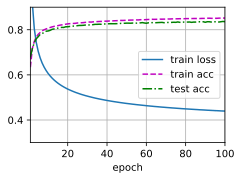

In [42]:
num_epochs = 100
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

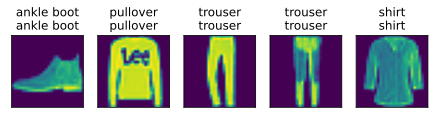

In [43]:
def predict_ch3(net, test_iter, n=6):  #@save
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter, n=5)

In [47]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [48]:
# PyTorch does not implicitly reshape the inputs. Thus we define the flatten
# layer to reshape the inputs before the linear layer in our network
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [49]:
loss = nn.CrossEntropyLoss(reduction='none')

In [50]:
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

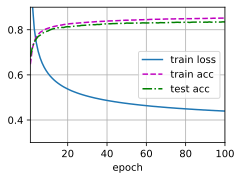

In [51]:
num_epochs = 100
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)